# How to generate a membership inference attacks report?

### Check that the synthetic data protect the privacy of the real data

Based on the Wisconsin Breast Cancer Dataset (WBCD)

In [1]:
# Standard library
import sys

sys.path.append("..")
import tempfile
from pathlib import Path

# 3rd party packages
import pandas as pd
from sklearn.model_selection import train_test_split

# Local packages
from generators.ctabgan_generator import CTABGANGenerator
from generators.ctgan_generator import CTGANGenerator
from generators.dataSynthesizer import DataSynthesizerGenerator
from generators.mst_generator import MSTGenerator
from generators.smote import SmoteGenerator
from generators.synthpop_generator import SynthpopGenerator
from generators.tabddpm_generator import TabDDPMGenerator
from generators.tvae_generator import TVAEGenerator
from metrics.privacy.report import PrivacyReport

## Generate synthetic data

### Load the Wisconsin Breast Cancer Dataset

In [2]:
df_real = pd.read_csv("../data/breast_cancer_wisconsin.csv").drop(
    "Sample_code_number", axis=1
)
df_real.shape

(683, 10)

In [3]:
df_real.head()

,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2
3,6,8,8,1,3,4,3,7,1,2
4,4,1,1,3,2,1,3,1,1,2


### Split the real data into train and test sets

In [4]:
df_real_train, df_real_test = train_test_split(
    df_real, test_size=1 / 3, random_state=42, stratify=df_real["Class"]
)

In [5]:
df_real_train.to_csv("../data/WBCD_train.csv", index=False)
df_real_test.to_csv("../data/WBCD_test.csv", index=False)

### Create the metadata dictionary
The continuous and categorical variables need to be specified, as well as the variable to predict for the future learning task (used by SMOTE)

In [6]:
metadata = {
    "continuous": [
        "Clump_Thickness",
        "Uniformity_of_Cell_Size",
        "Uniformity_of_Cell_Shape",
        "Marginal_Adhesion",
        "Single_Epithelial_Cell_Size",
        "Bland_Chromatin",
        "Normal_Nucleoli",
        "Mitoses",
        "Bare_Nuclei",
    ],
    "categorical": ["Class"],
    "variable_to_predict": "Class",
}

### Choose a generator
We choose synthpop as generator with default setting

In [7]:
gen = SynthpopGenerator(
    df=df_real_train,
    metadata=metadata,
    random_state=42,  # for reproducibility, can be set to None
    generator_filepath=None,  # to load an existing generator,
    variables_order=None,  # use the dataframe columns order by default
    min_samples_leaf=5,  # default = 5
    max_depth=None,
)

### Fit the generator to the real train data

In [8]:
gen.preprocess()
gen.fit(save_path="../results/attack/generator/1st_generation")  # the path should exist

### Generate synthetic data

In [9]:
df_synth_train = gen.sample(
    save_path="../results/attack/data/1st_generation",  # the path should exist
    num_samples=len(df_real_train),
)

In [10]:
df_synth_test = gen.sample(
    save_path="../results/attack/data/1st_generation",  # the path should exist
    num_samples=len(df_real_test),
)

### Generate 2nd generation synthetic data
We choose the same generator and setting to generate the 2nd generation synthetic data

In [11]:
gen_2nd = SynthpopGenerator(
    df=df_synth_train,
    metadata=metadata,
    random_state=42,  # for reproducibility, can be set to None
    generator_filepath=None,  # to load an existing generator,
    variables_order=None,  # use the dataframe columns order by default
    min_samples_leaf=5,  # default = 5
    max_depth=None,
)

In [12]:
gen_2nd.preprocess()
gen_2nd.fit(
    save_path="../results/attack/generator/2nd_generation"
)  # the path should exist

In [13]:
df_synth_2nd = gen_2nd.sample(
    save_path="../results/attack/data/2nd_generation",  # the path should exist
    num_samples=len(df_synth_train),
)

## Generate privacy report

### Gethor real and synthetic data into dictionaries

In [14]:
df_real_dict = {}
df_real_dict["train"] = df_real_train
df_real_dict["test"] = df_real_test

# 1st and 2nd generation synthetic data
df_synth_dict = {}
df_synth_dict["train"] = df_synth_train
df_synth_dict["test"] = df_synth_test
df_synth_dict["2nd_gen"] = df_synth_2nd

### Generate the privacy report

In [15]:
report = PrivacyReport(
    dataset_name="Wisconsin Breast Cancer Dataset",
    df_real=df_real_dict,
    df_synthetic=df_synth_dict,
    metadata=metadata,
    figsize=(8, 6),  # will be automatically adjusted for larger or longer figures
    random_state=42,  # for reproducibility purposes
    report_filepath=None,  # load a computed report if available
    metrics=None,  # list of the metrics to compute. If not specified, all the metrics are computed.
    sampling_frac=0.5,  # the fraction of data to sample from real and synthetic datasets for better computing performance
    num_repeat=10,  # for the metrics relying on predictions
    num_kfolds=3,  # the number of folds to tune the hyperparameters for the metrics relying on predictors
    num_optuna_trials=15,  # the number of trials of the optimization process for tuning hyperparameters for the metrics relying on predictors
    use_gpu=False,  # run the learning tasks on the GPU
)

In [16]:
report.compute()

LOGAN test set shape: (228, 10)
TableGan test set shape: (228, 10)
Detector test set shape: (228, 10)


### Get the summary report as a pandas dataframe

In [17]:
report.specification()

----- Wisconsin Breast Cancer Dataset -----
Contains:
    - 455 instances in the train set,
    - 228 instances in the test set,
    - 10 variables, 9 continuous and 1 categorical.


In [18]:
df_summary = report.summary()

In [19]:
by = ["name", "objective", "min", "max"]
df_summary.groupby(by).apply(lambda x: x.drop(by, axis=1).reset_index(drop=True))

alias  \
name                   objective min max                  
Collision              max       0   1.0 0    collision   
                                         1    collision   
                                         2    collision   
                                         3    collision   
                                     inf 0    collision   
                                         1    collision   
                                         2    collision   
                                         3    collision   
                                         4    collision   
DCR                    max       0   1.0 0          dcr   
                                         1          dcr   
                                     inf 0          dcr   
                                         1          dcr   
                       min       0   1.0 0          dcr   
                                         1          dcr   
Detector               max       0   1.0 0     detector   
                                         1     detector   
                                         2     detector   
                                         3     detector   
                                         4     detector   
GAN-Leaks              max       0   1.0 0     ganleaks   
                                         1     ganleaks   
LOGAN                  max       0   1.0 0        logan   
                                         1        logan   
                                         2        logan   
                                         3        logan   
                                         4        logan   
Monte Carlo Membership max       0   1.0 0  mcmebership   
                                         1  mcmebership   
TableGan               max       0   1.0 0     tablegan   
                                         1     tablegan   
                                         2     tablegan   
                                         3     tablegan   
                                         4     tablegan   

                                                                     submetric  \
name                   objective min max                                         
Collision              max       0   1.0 0                           precision   
                                         1                              recall   
                                         2                            f1_score   
                                         3                       recovery_rate   
                                     inf 0        avg_num_appearance_realtrain   
                                         1      avg_num_appearance_realcontrol   
                                         2            avg_num_appearance_synth   
                                         3   avg_num_appearance_collision_real   
                                         4  avg_num_appearance_collision_synth   
DCR                    max       0   1.0 0    nndr_5th_percent_synthreal_train   
                                         1  nndr_5th_percent_synthreal_control   
                                     inf 0     dcr_5th_percent_synthreal_train   
                                         1   dcr_5th_percent_synthreal_control   
                       min       0   1.0 0         ratio_match_synthreal_train   
                                         1       ratio_match_synthreal_control   
Detector               max       0   1.0 0                     precision_top1%   
                                         1                    precision_top50%   
                                         2                           precision   
                                         3                   tpr_at_0.001%_fpr   
                                         4                     tpr_at_0.1%_fpr   
GAN-Leaks              max       0   1.0 0                     precision_top1%   
                                       

### Display the detailed report

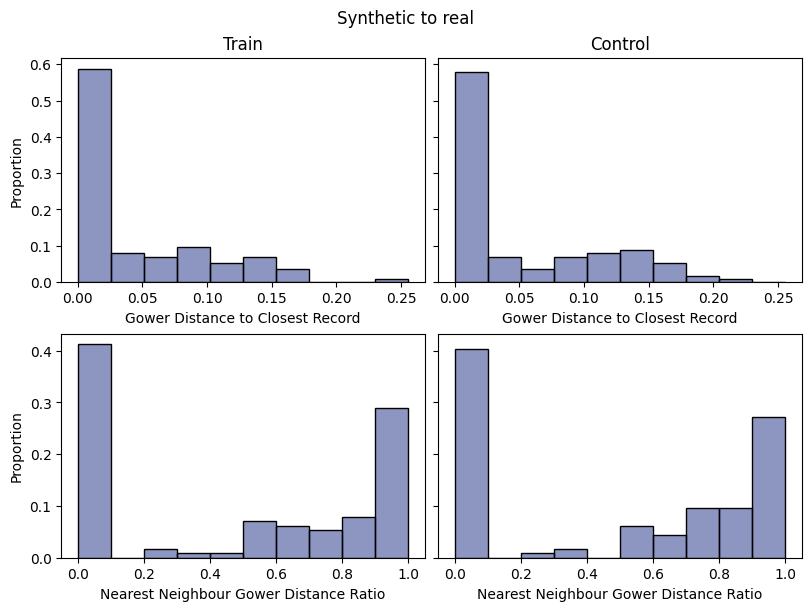

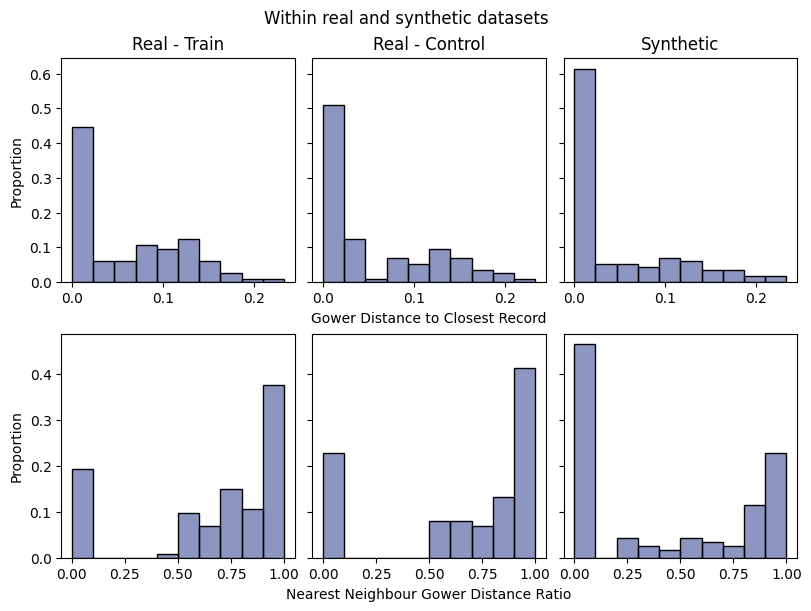

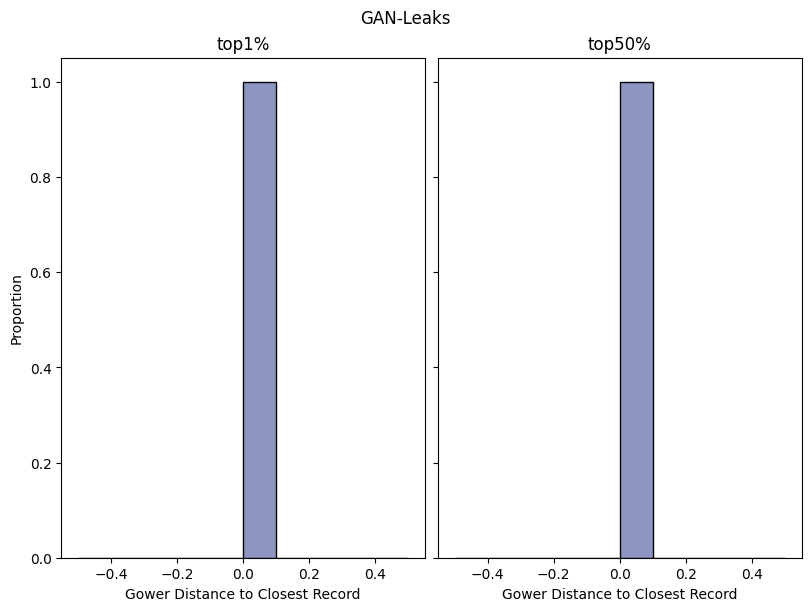

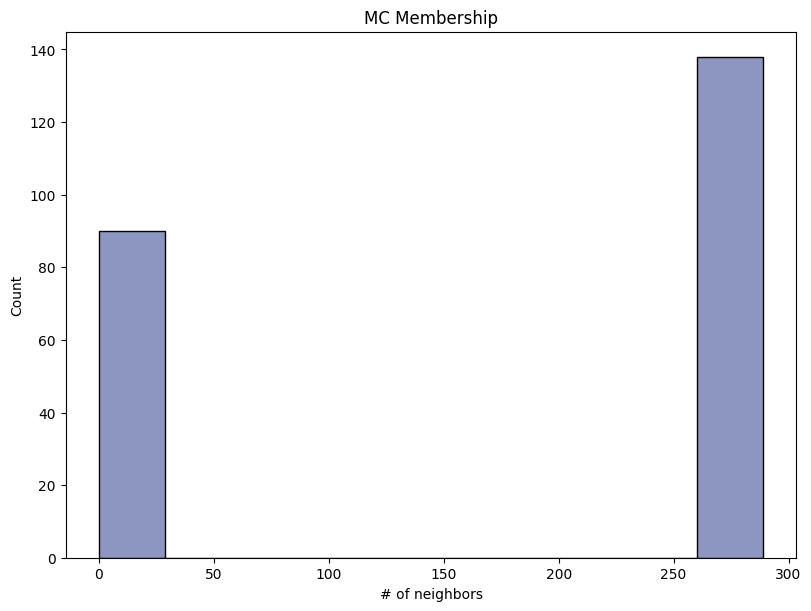

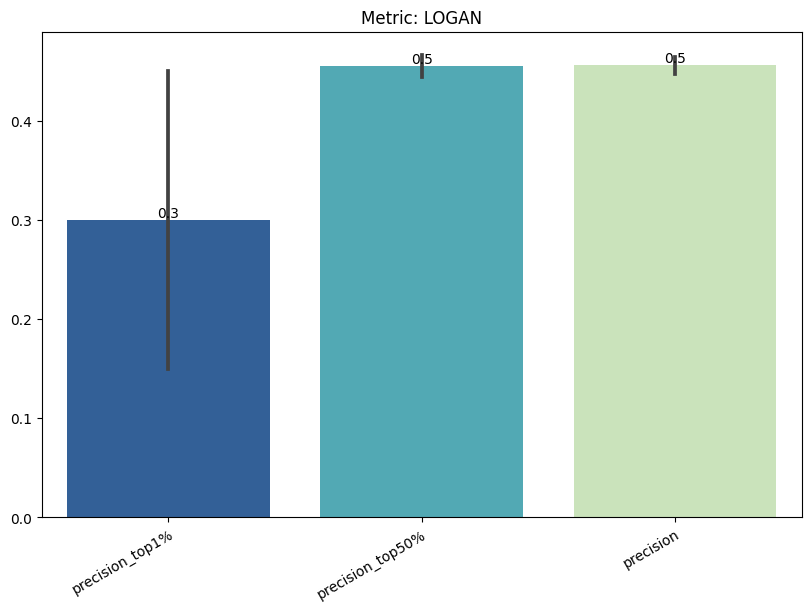

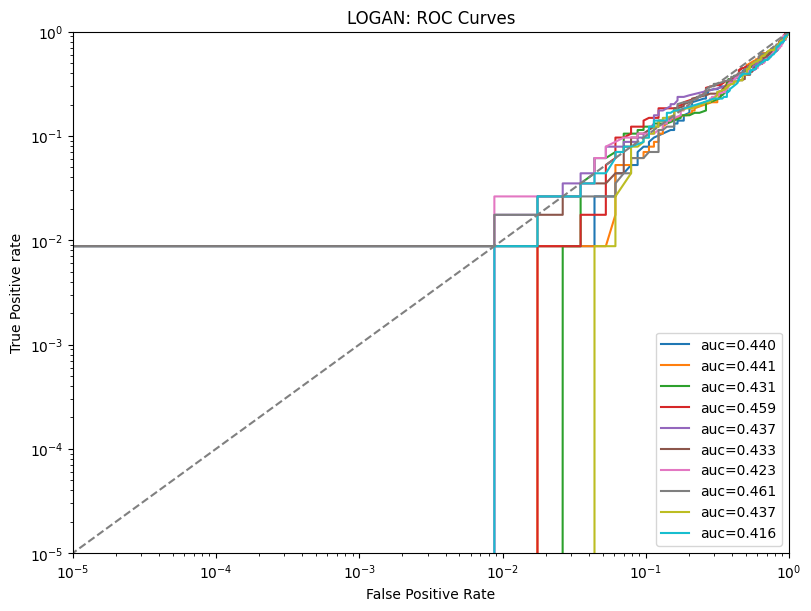

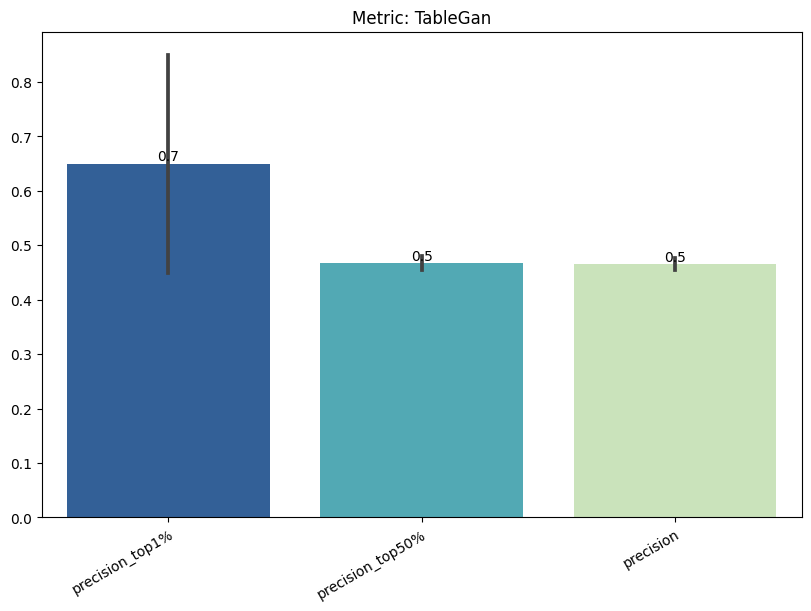

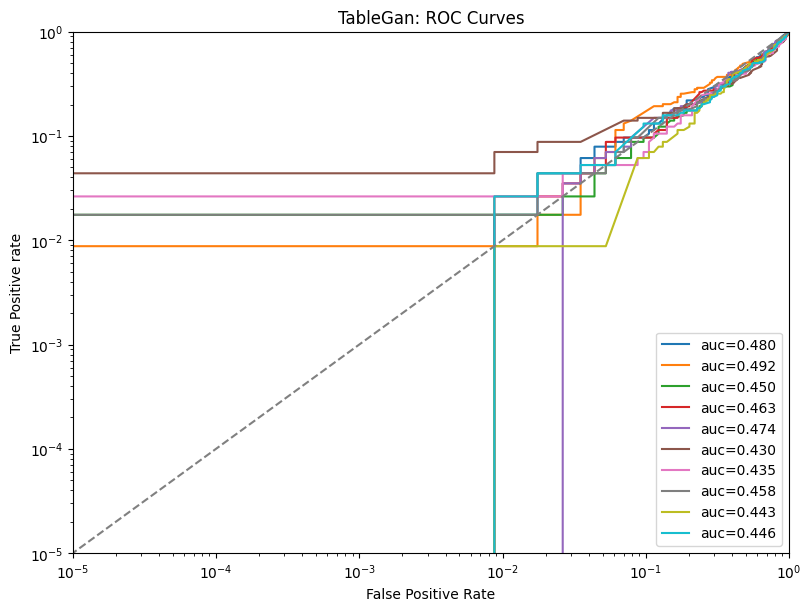

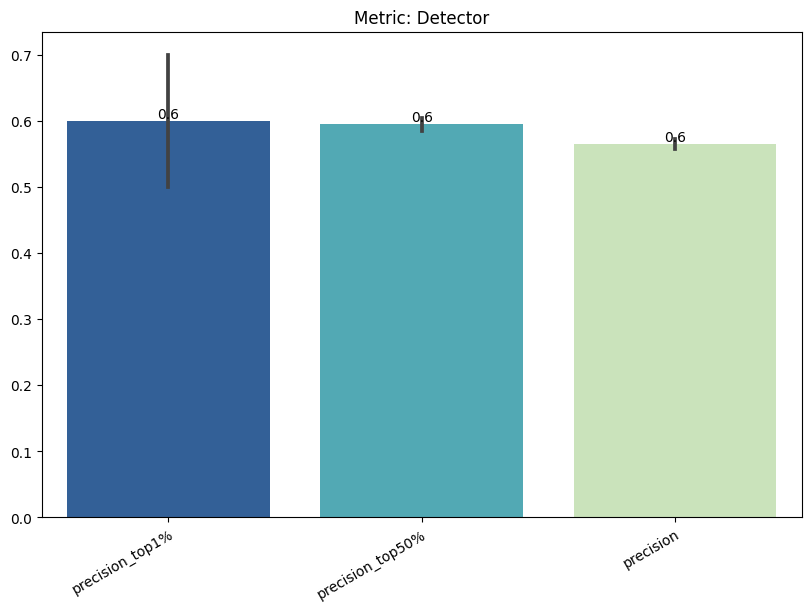

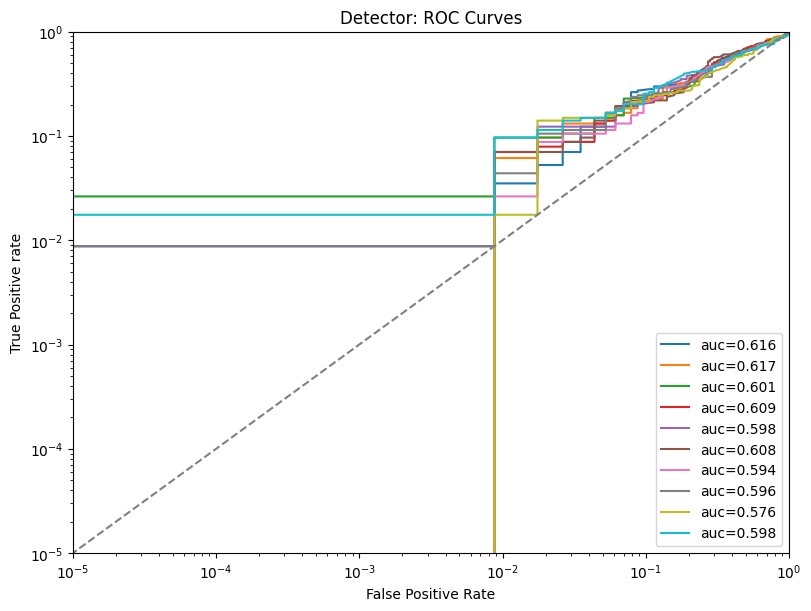

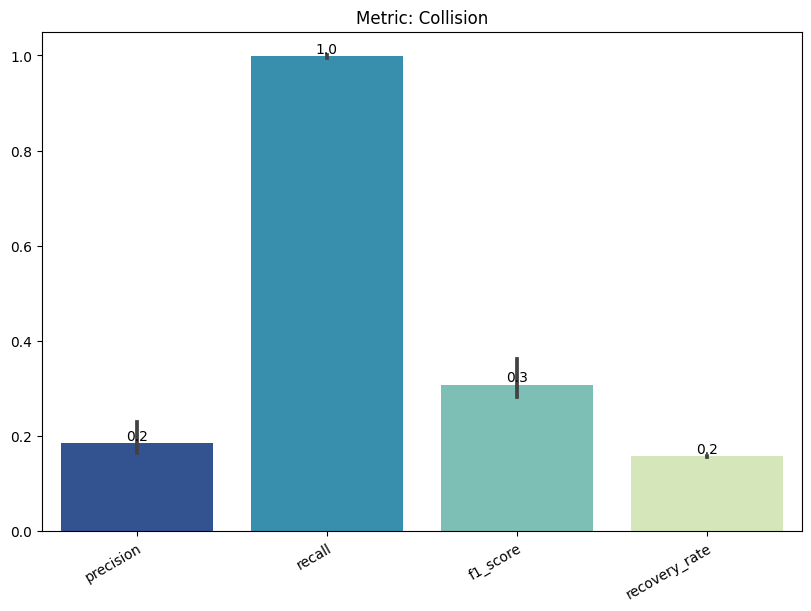

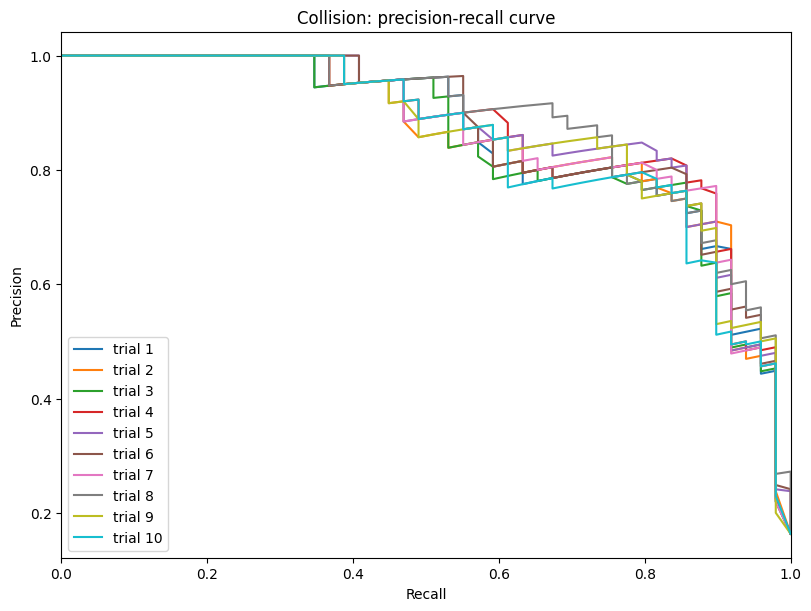

In [20]:
report.detailed(show=True, save_folder=None, figure_format="png")

### Save and load the report

In [ ]:
with tempfile.TemporaryDirectory() as temp_dir:
    report.save(savepath=temp_dir, filename="privacy_report")  # save
    new_report = PrivacyReport(
        report_filepath=Path(temp_dir) / "privacy_report.pkl"
    )  # load